In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [14]:
class_names = ['Can', 'Plastic']

# Model for train on Rasberry Pi, need to use tflite for lightweight model

In [16]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="models/ai-model-fp32.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

Input shape: [  1 224 224   3]
Output shape: [1 1]


In [17]:
# TFLite prediction function for Raspberry Pi
def predict_image_tflite(interpreter, img_path, class_names):
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Image not found.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # Convert to array - keep in [0, 255] range! Model has preprocessing built-in
    img_array = img_resized.astype("float32")  # NO /255 division!
    img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    p = float(output_data[0][0])
    
    # Interpret p = P(class 1 | x)
    if p >= 0.5:
        pred_cls = class_names[1]
        conf = p * 100
    else:
        pred_cls = class_names[0]
        conf = (1 - p) * 100
    
    print(f"[TFLite] Predicted: {pred_cls} ({conf:.2f}%)  | p(class_1)={p:.3f}")
    
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"TFLite: {pred_cls} ({conf:.1f}%)")
    plt.show()
    
    return pred_cls, conf

# Test TFLite Model (Raspberry Pi version)

[TFLite] Predicted: Can (100.00%)  | p(class_1)=0.000


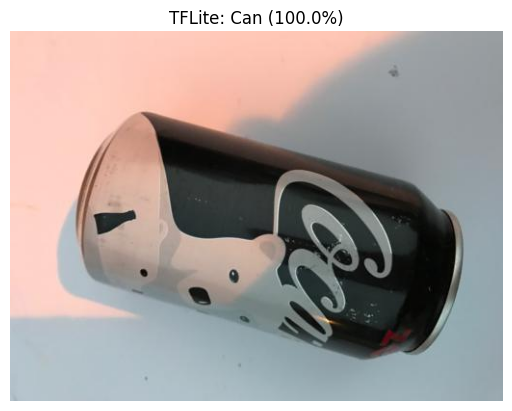

[TFLite] Predicted: Plastic (97.32%)  | p(class_1)=0.973


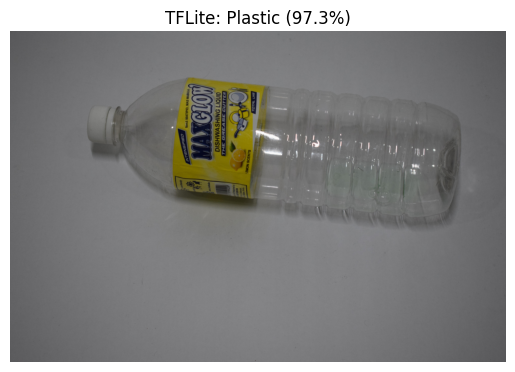

('Plastic', 97.3177969455719)

In [18]:
# Test TFLite predictions - should give same results as Keras model
predict_image_tflite(interpreter, 'AluCan61.jpg', class_names)
predict_image_tflite(interpreter, 'Plastic1.jpg', class_names)